<a href="https://colab.research.google.com/github/Noma999/RFM-Customer-Segmentation/blob/main/RFM_E_Commerce_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [20]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("tunguz/online-retail")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/online-retail


In [21]:
os.listdir(path)

['Online_Retail.csv']

 ***Dataset Overview***

Source: UCI Online Retail Dataset (https://archive.ics.uci.edu/ml/datasets/Online+Retail)

Description: Contains transactional data for a UK-based online retailer from 01-Dec-2010 to 09-Dec-2011.

Attributes:

InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

In [22]:
data = pd.read_csv(os.path.join(path, 'Online_Retail.csv'), encoding='latin-1')
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [24]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [25]:
# first 10000rows
#data=data.sample(n=1000,random_state=42)

In [26]:
# Drop missing values

data.dropna(subset=['CustomerID'],inplace=True)

In [27]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['TotalPrice']=data['Quantity']*data['UnitPrice']

/tmp/ipython-input-332481145.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])


In [28]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [29]:
referencedate=dt.datetime(2011,12,10)
data['Recency']=data['InvoiceDate'].apply(lambda x:(referencedate-x).days)

In [30]:
referencedate

datetime.datetime(2011, 12, 10, 0, 0)

**Data Cleaning and Preprocessing**

Tasks Performed

Dropped missing values: Focused only on entries with a valid CustomerID.


Created TotalPrice: Computed as Quantity * UnitPrice to represent transaction value. Converted InvoiceDate to datetime format.

Defined Reference Date:Set to 2011-12-10 for recency calculation.



In [31]:
rfm=data.groupby('CustomerID').agg({
     'InvoiceDate':lambda x:(referencedate-x).dt.days.min(),
    'InvoiceNo':'count',
    'TotalPrice':'sum'
})

In [32]:
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'},inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [33]:
# Calculation of the Recency Score
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

#Calculation of the Frequency Score
#rank usage: it is a method for assigning a value to multiple repeated expressions (a value falling into 2 different categories, etc.).
rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#Calculating the Monetary Score
rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

#Calculation of the RF Score
rfm["RFM_SEGMENT"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str)+rfm["monetary_score"].astype(str))

rfm['RFM_SCORE']=rfm[['recency_score','frequency_score','monetary_score']].sum(axis=1)
# View of Dataframe
rfm.head(10)

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SEGMENT,RFM_SCORE
CustomerID,,,,,,,,
12346.0,325,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,5,5,5,555,15
12348.0,75,31,1797.24,2,3,4,234,9
12349.0,18,73,1757.55,4,4,4,444,12
12350.0,310,17,334.40,1,2,2,122,5
12352.0,36,95,1545.41,3,4,4,344,11
12353.0,204,4,89.00,1,1,1,111,3
12354.0,232,58,1079.40,1,3,4,134,8
12355.0,214,13,459.40,1,1,2,112,4


In [34]:
# Rescaling the attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

Finding Optimal No of Cluster Using Elboe and Silhouette Technique

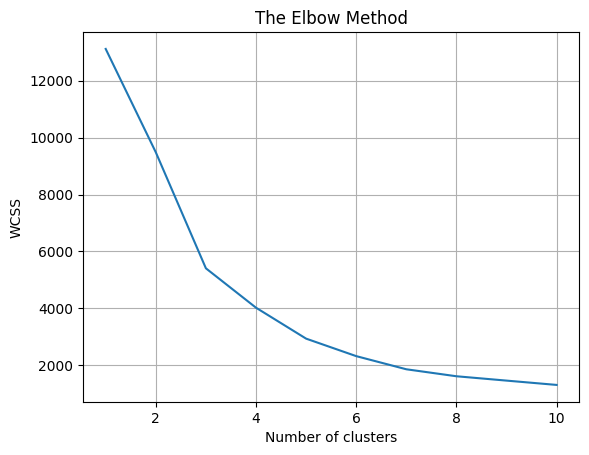

In [35]:
#the elbow technique
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

No of clusters from elbwo technique is 3

For n_clusters=2, the silhouette score is 0.9344627710411026
For n_clusters=3, the silhouette score is 0.6000464075533437
For n_clusters=4, the silhouette score is 0.5988120960943756
For n_clusters=5, the silhouette score is 0.6148313030908178
For n_clusters=6, the silhouette score is 0.5916112815681613
For n_clusters=7, the silhouette score is 0.5235666270458774
For n_clusters=8, the silhouette score is 0.5295602417794409
For n_clusters=9, the silhouette score is 0.4718182056565845
For n_clusters=10, the silhouette score is 0.4279794464171725


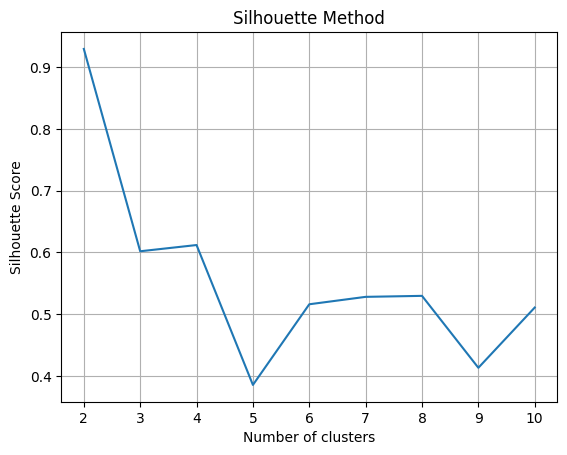

In [36]:
# Silhouette analysis
for num_clusters in range(2,11):

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

sil = []
for k in range(2, 11):
    km = KMeans(n_clusters=k).fit(rfm_df_scaled)
    sil.append(silhouette_score(rfm_df_scaled, km.labels_))

plt.plot(range(2,11), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid()
plt.show()

Higher silhouette score shows best clustering, therefore 2,3,5 respectively will work

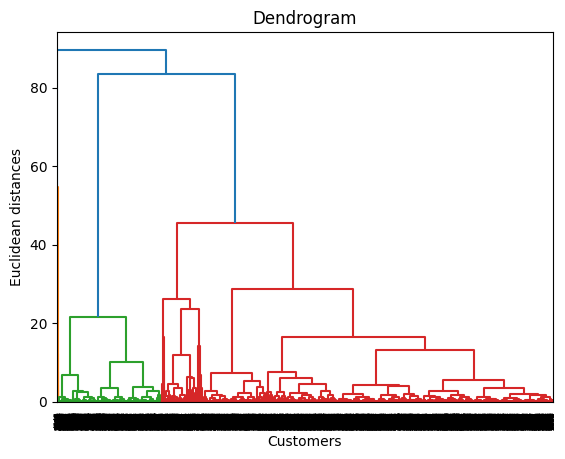

In [38]:
#using dendrogram
import scipy.cluster.hierarchy as sch
dendrogram=sch.dendrogram(sch.linkage(rfm_df_scaled,method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [39]:
kmeans= KMeans(n_clusters=3,init='k-means++',random_state=42)
y_kmeans=kmeans.fit_predict(rfm_df_scaled)

In [40]:
kmeans.cluster_centers_

array([[ 6.59081938e-03,  5.12242810e-02, -5.15233538e-01],
       [-1.74592159e-01, -2.80991660e-01,  1.53641095e+00],
       [ 1.42137753e+01,  1.18416391e+01, -8.65892553e-01]])

<Figure size 800x600 with 0 Axes>

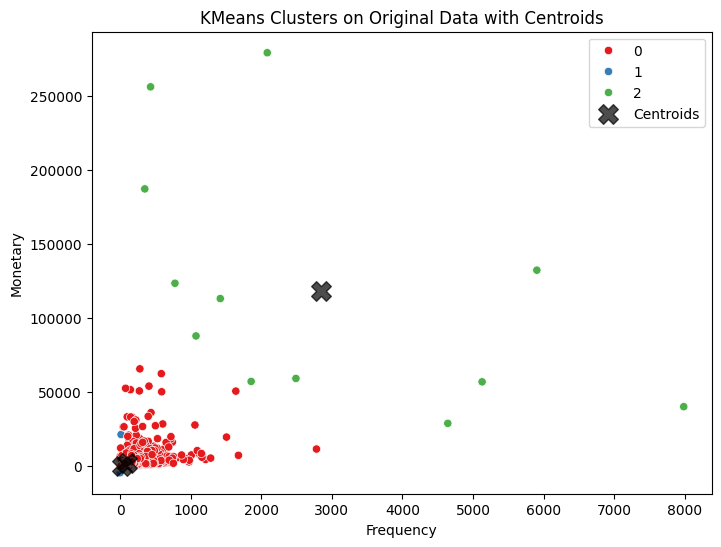

In [47]:
#plot clusters and centrods with seaborn
plt.figure(figsize=(8,6))

# Convert the scaled array back to a DataFrame with column names
# rfm_df_scaled_df = pd.DataFrame(rfm_df_scaled, columns=rfm_df.columns)

# Add the cluster labels to the DataFrame
rfm['Cluster'] = y_kmeans

# Now use the original DataFrame for plotting

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set1')


# Plotting centroids on the original scale is tricky as they are calculated on the scaled data.
# You could inverse transform them if needed, but often visualizing clusters on original data is enough.
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',label='Centroids')

# Inverse transform the centroids back to the original scale
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)

# Plot the centroids on the scatter plot
plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], c='black', s=200, alpha=0.7, label='Centroids', marker='X')

plt.legend()
plt.title('KMeans Clusters on Original Data with Centroids')
plt.show()

In [42]:
#DESCAN
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=1.58, min_samples=5)
y_dbscan=dbscan.fit_predict(rfm_df_scaled)

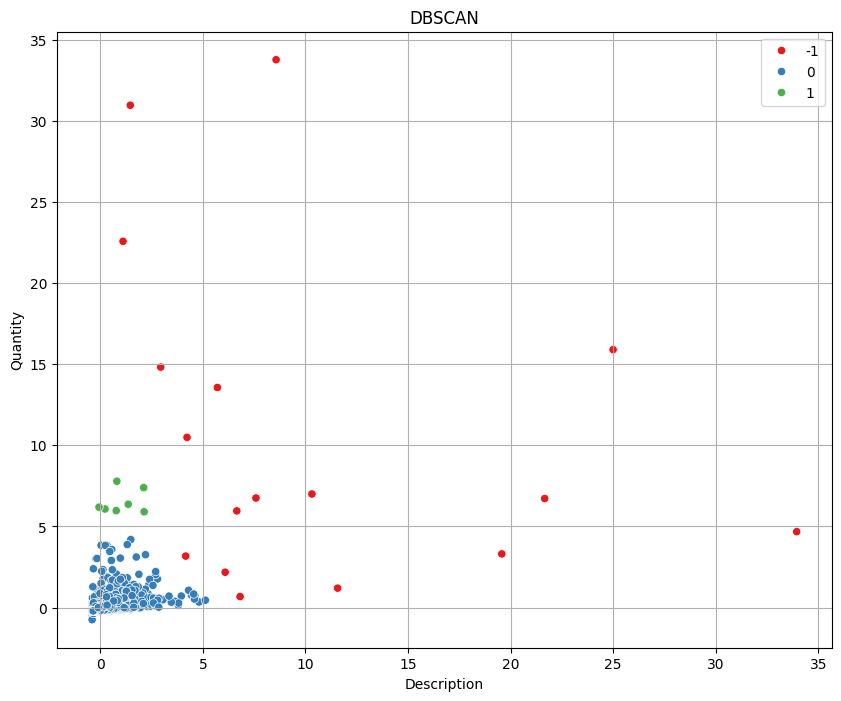

In [44]:
#plot
plt.figure(figsize=(10,8))
sns.scatterplot(data=rfm_df_scaled_df, x="Frequency", y="Monetary", hue=y_dbscan, palette='Set1')
plt.title('DBSCAN')
plt.xlabel('Description')
plt.ylabel('Quantity')
plt.grid()
plt.show()

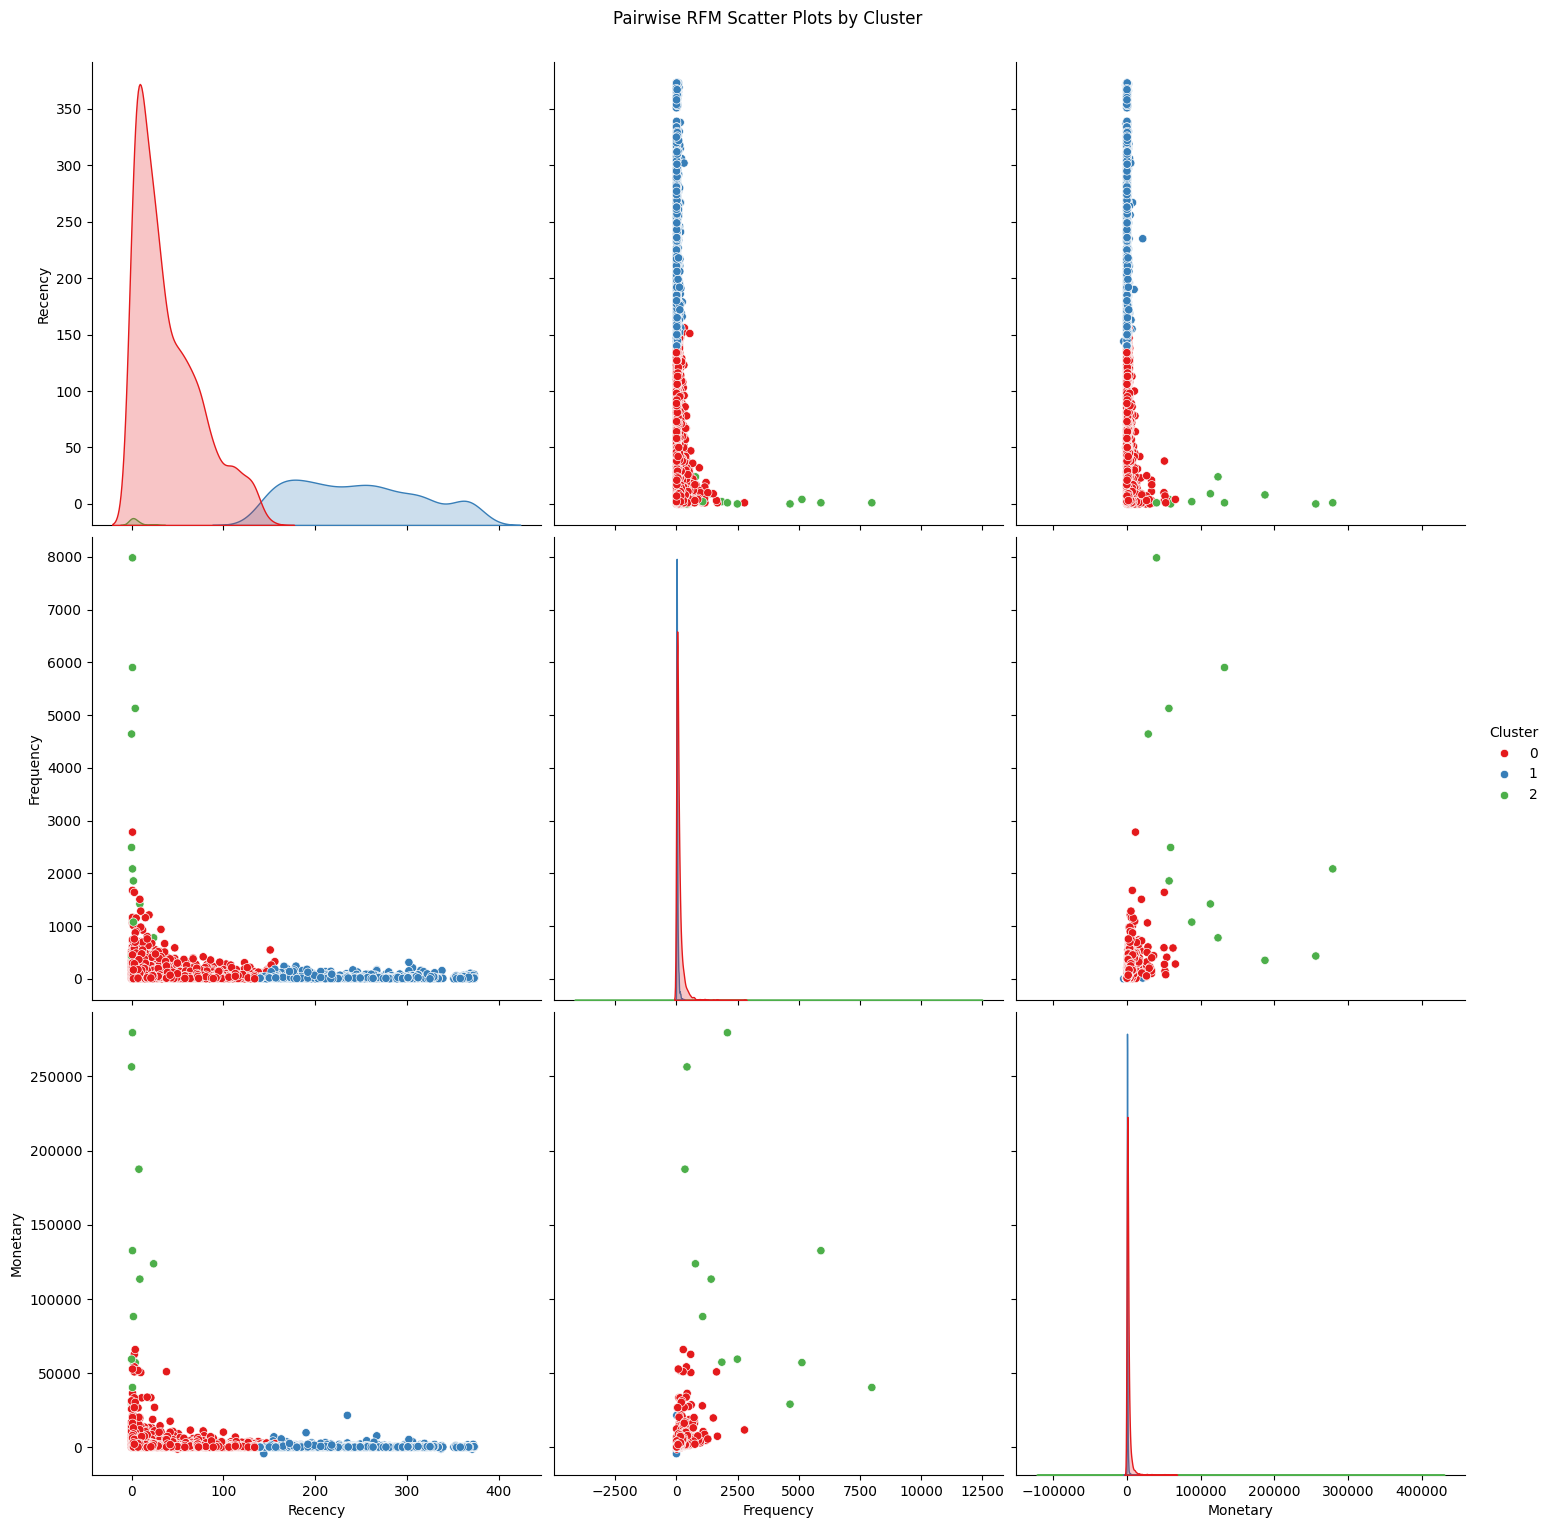

In [50]:
# Plotting pairwise scatter plots for RFM with cluster labels
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='Set1', diag_kind='kde', height=5)
plt.suptitle('Pairwise RFM Scatter Plots by Cluster', y=1.02) # Add a title
plt.show()